In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import warnings

In [3]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [5]:
# Set visual styles
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

# Load the Excel file
excel_path = "/content/Customer_Churn_Data_Large.xlsx"
xls = pd.ExcelFile(excel_path)

In [6]:
# List all sheet names
print("===== AVAILABLE SHEETS IN THE EXCEL FILE =====")
print(xls.sheet_names)

===== AVAILABLE SHEETS IN THE EXCEL FILE =====
['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status']


In [7]:
# Load each sheet into a separate DataFrame
demographics_df = pd.read_excel(excel_path, sheet_name='Customer_Demographics')
transactions_df = pd.read_excel(excel_path, sheet_name='Transaction_History')
service_df = pd.read_excel(excel_path, sheet_name='Customer_Service')
online_df = pd.read_excel(excel_path, sheet_name='Online_Activity')
churn_df = pd.read_excel(excel_path, sheet_name='Churn_Status')

In [8]:
# Display the column names of each dataframe to identify the ID columns
print("\n===== COLUMN NAMES IN EACH DATAFRAME =====")
print("Demographics columns:", demographics_df.columns.tolist())
print("Transactions columns:", transactions_df.columns.tolist())
print("Service columns:", service_df.columns.tolist())
print("Online Activity columns:", online_df.columns.tolist())
print("Churn Status columns:", churn_df.columns.tolist())



===== COLUMN NAMES IN EACH DATAFRAME =====
Demographics columns: ['CustomerID', 'Age', 'Gender', 'MaritalStatus', 'IncomeLevel']
Transactions columns: ['CustomerID', 'TransactionID', 'TransactionDate', 'AmountSpent', 'ProductCategory']
Service columns: ['CustomerID', 'InteractionID', 'InteractionDate', 'InteractionType', 'ResolutionStatus']
Online Activity columns: ['CustomerID', 'LastLoginDate', 'LoginFrequency', 'ServiceUsage']
Churn Status columns: ['CustomerID', 'ChurnStatus']


In [9]:
# Display the first few rows of each dataframe
print("\n===== CUSTOMER DEMOGRAPHICS =====")
print(demographics_df.head())



===== CUSTOMER DEMOGRAPHICS =====
   CustomerID  Age Gender MaritalStatus IncomeLevel
0           1   62      M        Single         Low
1           2   65      M       Married         Low
2           3   18      M        Single         Low
3           4   21      M       Widowed         Low
4           5   21      M      Divorced      Medium


In [10]:
print("\n===== TRANSACTION HISTORY =====")
print(transactions_df.head())


===== TRANSACTION HISTORY =====
   CustomerID  TransactionID TransactionDate  AmountSpent ProductCategory
0           1           7194      2022-03-27       416.50     Electronics
1           2           7250      2022-08-08        54.96        Clothing
2           2           9660      2022-07-25       197.50     Electronics
3           2           2998      2022-01-25       101.31       Furniture
4           2           1228      2022-07-24       397.37        Clothing


In [11]:
print("\n===== CUSTOMER SERVICE =====")
print(service_df.head())


===== CUSTOMER SERVICE =====
   CustomerID  InteractionID InteractionDate InteractionType ResolutionStatus
0           1           6363      2022-03-31         Inquiry         Resolved
1           2           3329      2022-03-17         Inquiry         Resolved
2           3           9976      2022-08-24         Inquiry         Resolved
3           4           7354      2022-11-18         Inquiry         Resolved
4           4           5393      2022-07-03         Inquiry       Unresolved


In [12]:
print("\n===== ONLINE ACTIVITY =====")
print(online_df.head())


===== ONLINE ACTIVITY =====
   CustomerID LastLoginDate  LoginFrequency ServiceUsage
0           1    2023-10-21              34   Mobile App
1           2    2023-12-05               5      Website
2           3    2023-11-15               3      Website
3           4    2023-08-25               2      Website
4           5    2023-10-27              41      Website


In [13]:
print("\n===== CHURN STATUS =====")
print(churn_df.head())


===== CHURN STATUS =====
   CustomerID  ChurnStatus
0           1            0
1           2            1
2           3            0
3           4            0
4           5            0


In [14]:
print("\n===== PHASE 1: EXPLORATORY DATA ANALYSIS =====")



===== PHASE 1: EXPLORATORY DATA ANALYSIS =====


In [85]:
 # Function to perform basic EDA on a DataFrame
def perform_basic_eda(df, title):
    print(f"\n----- {title} EDA -----")

    # Shape
    print(f"Shape: {df.shape}")

    # Data types
    print("\nData Types:")
    print(df.dtypes)

    # Missing values
    print("\nMissing Values:")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_info = pd.DataFrame({'Missing Values': missing,
                                'Percentage': missing_percent})
    print(missing_info[missing_info['Missing Values'] > 0])

    # Descriptive statistics for numerical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        print("\nDescriptive Statistics for Numerical Columns:")
        print(df[numeric_cols].describe())

    # Frequency counts for categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print("\nFrequency Counts for Categorical Columns:")
        for col in categorical_cols:
            print(f"\n{col}:")
            print(df[col].value_counts())
            print(f"Unique values: {df[col].nunique()}")


In [86]:
# Perform EDA on each DataFrame
perform_basic_eda(demographics_df, "Customer Demographics")
perform_basic_eda(transactions_df, "Transaction History")
perform_basic_eda(service_df, "Customer Service")
perform_basic_eda(online_df, "Online Activity")
perform_basic_eda(churn_df, "Churn Status")


----- Customer Demographics EDA -----
Shape: (1000, 5)

Data Types:
CustomerID        int64
Age               int64
Gender           object
MaritalStatus    object
IncomeLevel      object
dtype: object

Missing Values:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []

Descriptive Statistics for Numerical Columns:
        CustomerID          Age
count  1000.000000  1000.000000
mean    500.500000    43.267000
std     288.819436    15.242311
min       1.000000    18.000000
25%     250.750000    30.000000
50%     500.500000    43.000000
75%     750.250000    56.000000
max    1000.000000    69.000000

Frequency Counts for Categorical Columns:

Gender:
Gender
F    513
M    487
Name: count, dtype: int64
Unique values: 2

MaritalStatus:
MaritalStatus
Widowed     276
Married     261
Divorced    248
Single      215
Name: count, dtype: int64
Unique values: 4

IncomeLevel:
IncomeLevel
High      349
Medium    326
Low       325
Name: count, dtype: int64
Unique values: 3

----- Transa

In [87]:
# Merge dataframes using the correct column names
print("\n===== MERGING DATASETS =====")
# Use the actual column names provided
demographics_id = 'CustomerID'
transactions_id = 'CustomerID'
service_id = 'CustomerID'
online_id = 'CustomerID'
churn_id = 'CustomerID'

print(f"Merging on these ID columns:")
print(f"Demographics: {demographics_id}")
print(f"Transactions: {transactions_id}")
print(f"Service: {service_id}")
print(f"Online: {online_id}")
print(f"Churn: {churn_id}")




===== MERGING DATASETS =====
Merging on these ID columns:
Demographics: CustomerID
Transactions: CustomerID
Service: CustomerID
Online: CustomerID
Churn: CustomerID


In [88]:
# Merging the dataframes
df_full = demographics_df.merge(transactions_df, on=demographics_id, how='left')\
                         .merge(service_df, on=demographics_id, how='left')\
                         .merge(online_df, on=demographics_id, how='left')\
                         .merge(churn_df, on=demographics_id, how='left')

print("\n===== MERGED DATASET =====")
print(f"Shape: {df_full.shape}")
print(df_full.head())



===== MERGED DATASET =====
Shape: (6812, 17)
   CustomerID  Age Gender MaritalStatus IncomeLevel  TransactionID  \
0           1   62      M        Single         Low           7194   
1           2   65      M       Married         Low           7250   
2           2   65      M       Married         Low           9660   
3           2   65      M       Married         Low           2998   
4           2   65      M       Married         Low           1228   

  TransactionDate  AmountSpent ProductCategory  InteractionID InteractionDate  \
0      2022-03-27       416.50     Electronics         6363.0      2022-03-31   
1      2022-08-08        54.96        Clothing         3329.0      2022-03-17   
2      2022-07-25       197.50     Electronics         3329.0      2022-03-17   
3      2022-01-25       101.31       Furniture         3329.0      2022-03-17   
4      2022-07-24       397.37        Clothing         3329.0      2022-03-17   

  InteractionType ResolutionStatus LastLoginDa

In [89]:
# Check for missing values in the merged dataframe
print("\nMissing Values in Merged Dataset:")
missing = df_full.isnull().sum()
missing_percent = (missing / len(df_full)) * 100
missing_info = pd.DataFrame({'Missing Values': missing,
                            'Percentage': missing_percent})
print(missing_info[missing_info['Missing Values'] > 0])



Missing Values in Merged Dataset:
                  Missing Values  Percentage
InteractionID               1608   23.605402
InteractionDate             1608   23.605402
InteractionType             1608   23.605402
ResolutionStatus            1608   23.605402


In [24]:
# Check for missing values in the merged dataframe
print("\nMissing Values in Merged Dataset:")
missing = df_full.isnull().sum()
missing_percent = (missing / len(df_full)) * 100
missing_info = pd.DataFrame({'Missing Values': missing,
                            'Percentage': missing_percent})
print(missing_info[missing_info['Missing Values'] > 0])



Missing Values in Merged Dataset:
                  Missing Values  Percentage
InteractionID               1608   23.605402
InteractionDate             1608   23.605402
InteractionType             1608   23.605402
ResolutionStatus            1608   23.605402


In [90]:
# Handle duplicates (if any)
print("\nChecking for duplicates...")
duplicates = df_full.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    df_full = df_full.drop_duplicates()
    print(f"Duplicates removed. New shape: {df_full.shape}")



Checking for duplicates...
Number of duplicate rows: 0


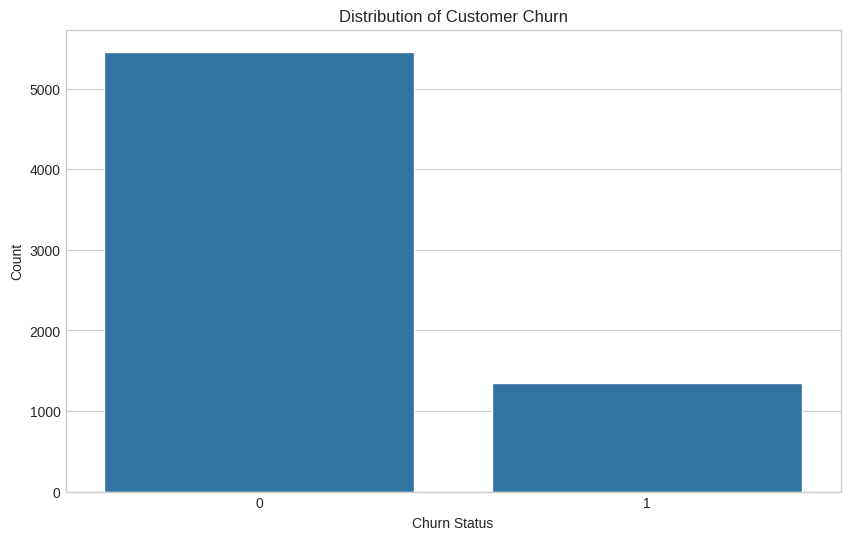

In [91]:
# Visualize the distribution of churn
plt.figure(figsize=(10, 6))
sns.countplot(x='ChurnStatus', data=df_full)
plt.title('Distribution of Customer Churn')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.show()

In [92]:
# Calculate churn rate
churn_rate = df_full['ChurnStatus'].mean() * 100
print(f"\nOverall Churn Rate: {churn_rate:.2f}%")


Overall Churn Rate: 19.85%


In [93]:
# Analyze churn by demographics
print("\n===== CHURN ANALYSIS BY DEMOGRAPHICS =====")


===== CHURN ANALYSIS BY DEMOGRAPHICS =====


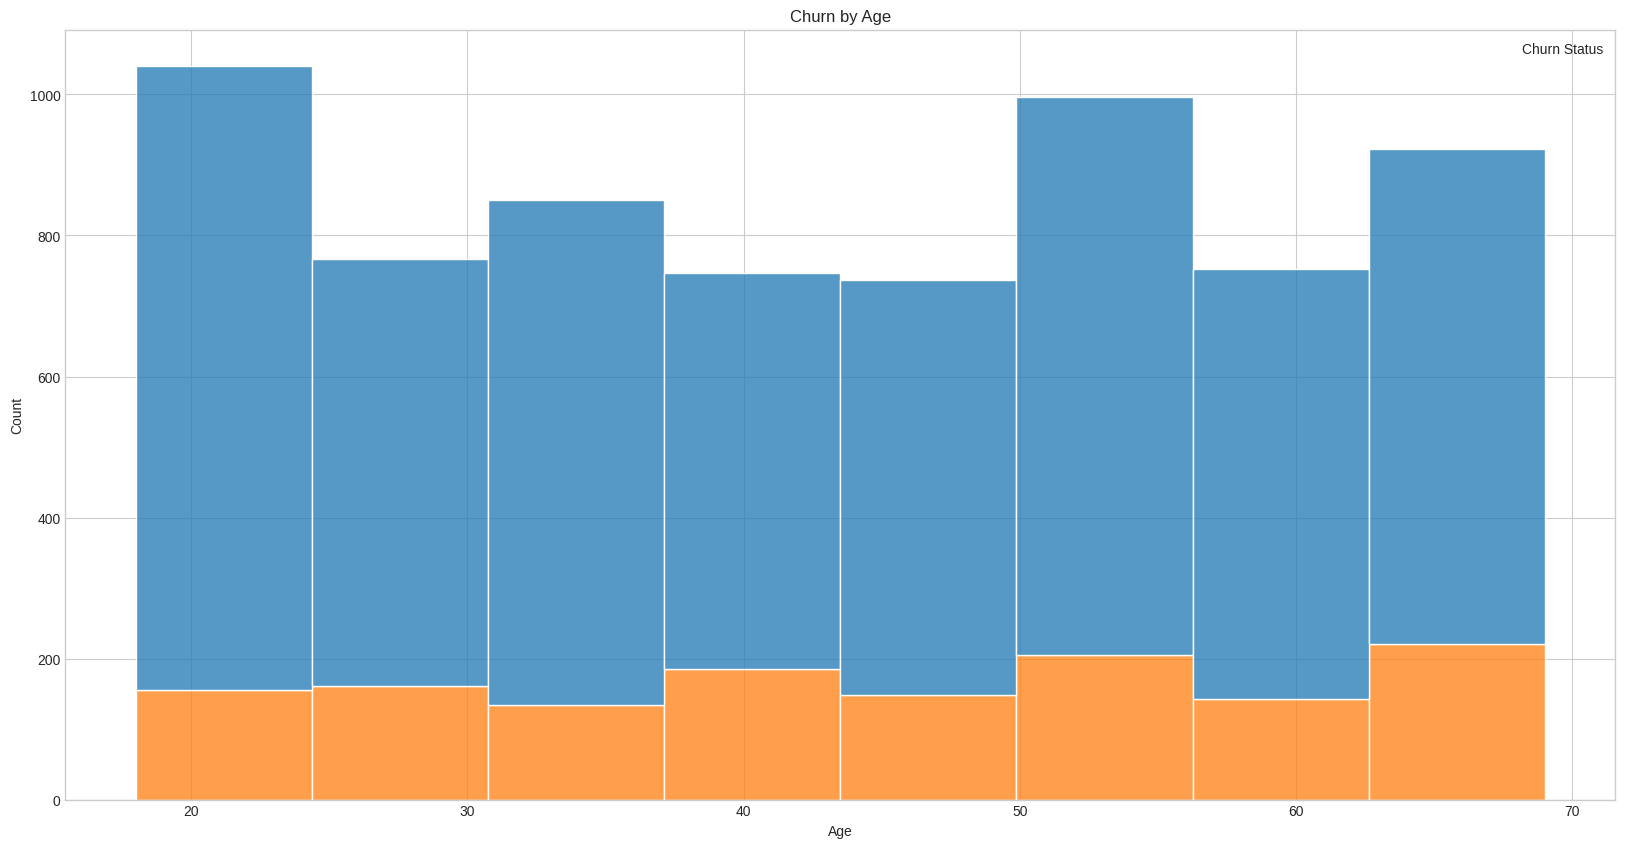

In [94]:
# Age analysis
plt.figure(figsize=(20, 10))
sns.histplot(data=df_full, x='Age', hue='ChurnStatus', multiple='stack', bins=8)
plt.title('Churn by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Churn Status')
plt.show()


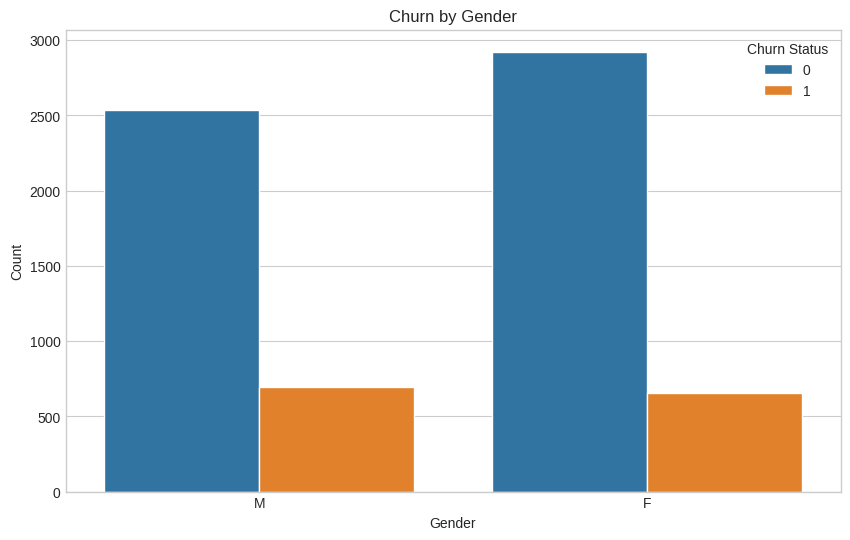

In [95]:
# Gender analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='ChurnStatus', data=df_full)
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churn Status')
plt.show()

In [96]:
# Calculate churn rate by gender
churn_by_gender = df_full.groupby('Gender')['ChurnStatus'].mean() * 100
print("\nChurn Rate by Gender:")
print(churn_by_gender)


Churn Rate by Gender:
Gender
F    18.324022
M    21.534653
Name: ChurnStatus, dtype: float64


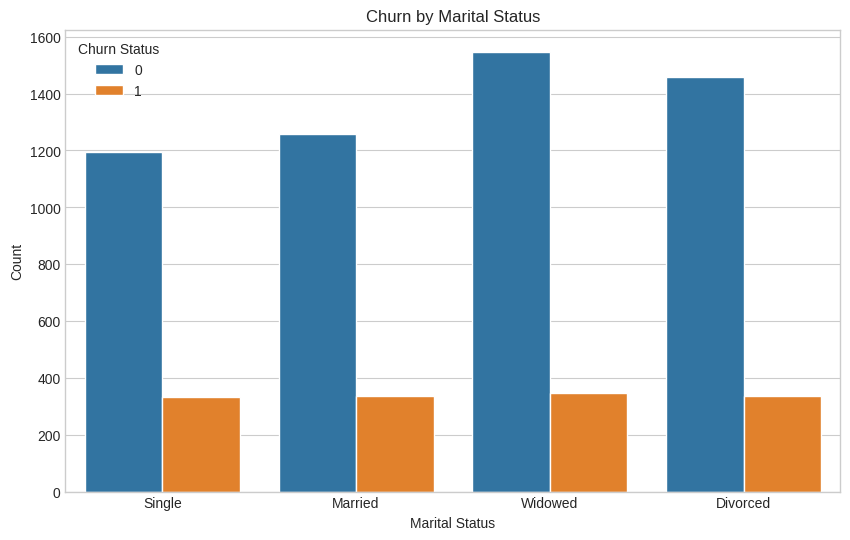

In [97]:
# Marital Status analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='MaritalStatus', hue='ChurnStatus', data=df_full)
plt.title('Churn by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Churn Status')
plt.show()

In [98]:
# Calculate churn rate by marital status
churn_by_marital = df_full.groupby('MaritalStatus')['ChurnStatus'].mean() * 100
print("\nChurn Rate by Marital Status:")
print(churn_by_marital)



Churn Rate by Marital Status:
MaritalStatus
Divorced    18.683770
Married     21.128527
Single      21.727749
Widowed     18.354430
Name: ChurnStatus, dtype: float64


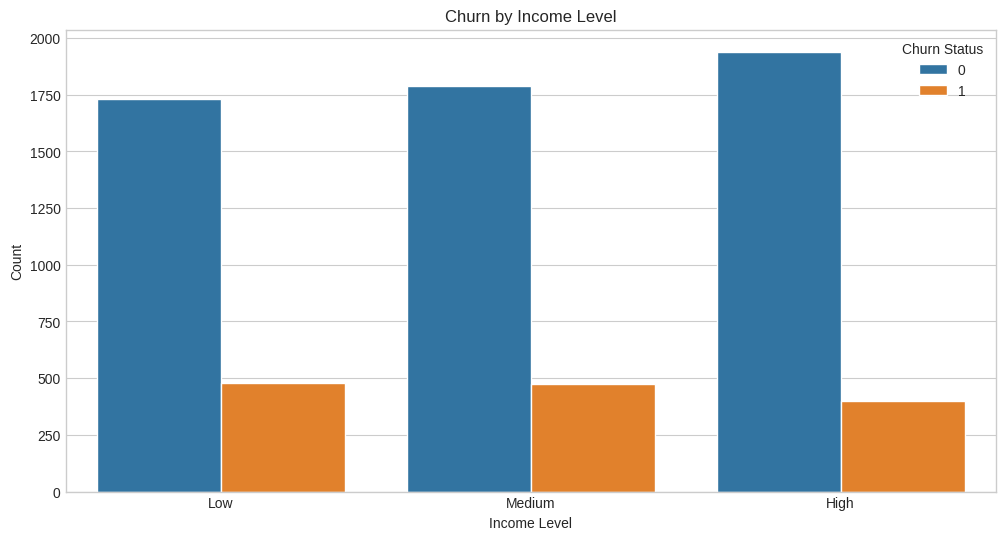

In [99]:

# Income level analysis
plt.figure(figsize=(12, 6))
sns.countplot(x='IncomeLevel', hue='ChurnStatus', data=df_full)
plt.title('Churn by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.legend(title='Churn Status')
plt.show()

In [100]:
# Calculate churn rate by income level
churn_by_income = df_full.groupby('IncomeLevel')['ChurnStatus'].mean() * 100
print("\nChurn Rate by Income Level:")
print(churn_by_income)


Churn Rate by Income Level:
IncomeLevel
High      17.094017
Low       21.613049
Medium    20.971302
Name: ChurnStatus, dtype: float64


In [101]:
print("\n===== CHURN ANALYSIS BY TRANSACTION METRICS =====")


===== CHURN ANALYSIS BY TRANSACTION METRICS =====


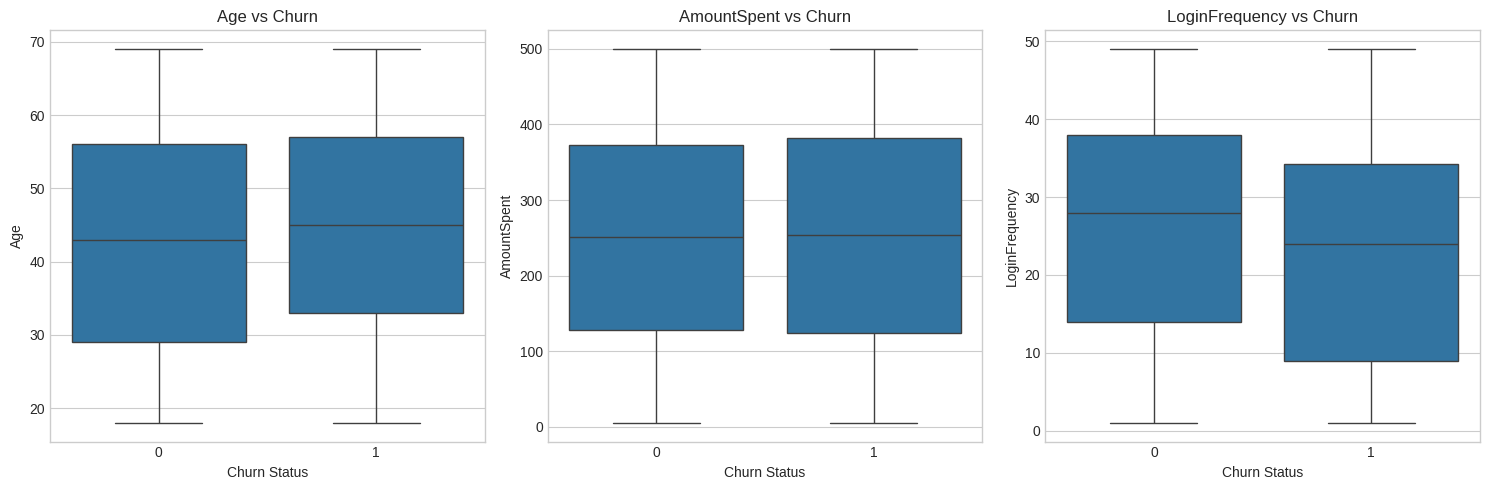

In [102]:
# Using the actual column names from the dataset
numerical_cols = ['Age', 'AmountSpent', 'LoginFrequency']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='ChurnStatus', y=col, data=df_full)
    plt.title(f'{col} vs Churn')
    plt.xlabel('Churn Status')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

<Figure size 1800x1000 with 0 Axes>

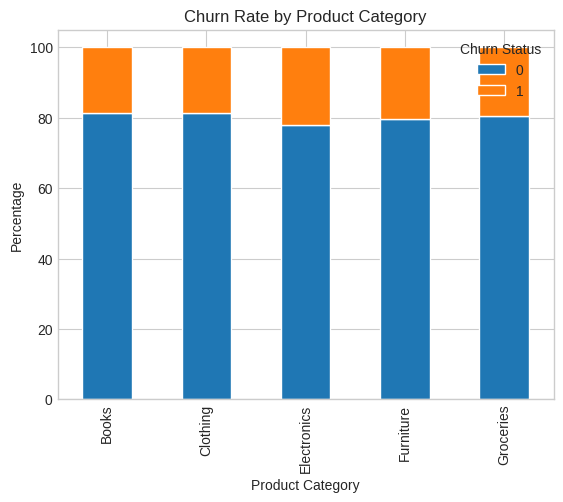

In [103]:
# Product Category analysis
plt.figure(figsize=(18, 10))
product_churn = pd.crosstab(df_full['ProductCategory'], df_full['ChurnStatus'], normalize='index') * 100
product_churn.plot(kind='bar', stacked=True)
plt.title('Churn Rate by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Percentage')
plt.legend(title='Churn Status')
plt.show()

<Figure size 1200x600 with 0 Axes>

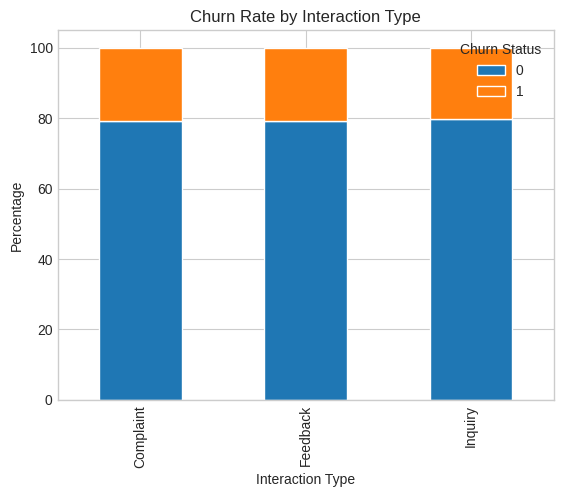

In [104]:
# Interaction Type analysis
plt.figure(figsize=(12, 6))
interaction_churn = pd.crosstab(df_full['InteractionType'], df_full['ChurnStatus'], normalize='index') * 100
interaction_churn.plot(kind='bar', stacked=True)
plt.title('Churn Rate by Interaction Type')
plt.xlabel('Interaction Type')
plt.ylabel('Percentage')
plt.legend(title='Churn Status')
plt.show()

<Figure size 1200x600 with 0 Axes>

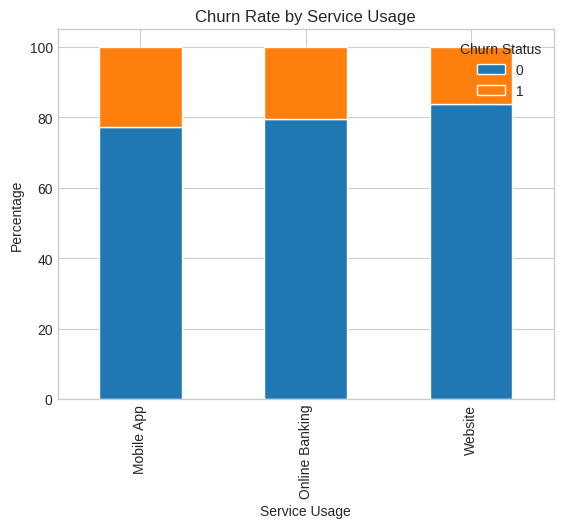

In [105]:
# Service Usage analysis
plt.figure(figsize=(12, 6))
service_churn = pd.crosstab(df_full['ServiceUsage'], df_full['ChurnStatus'], normalize='index') * 100
service_churn.plot(kind='bar', stacked=True)
plt.title('Churn Rate by Service Usage')
plt.xlabel('Service Usage')
plt.ylabel('Percentage')
plt.legend(title='Churn Status')
plt.show()


<Figure size 1200x600 with 0 Axes>

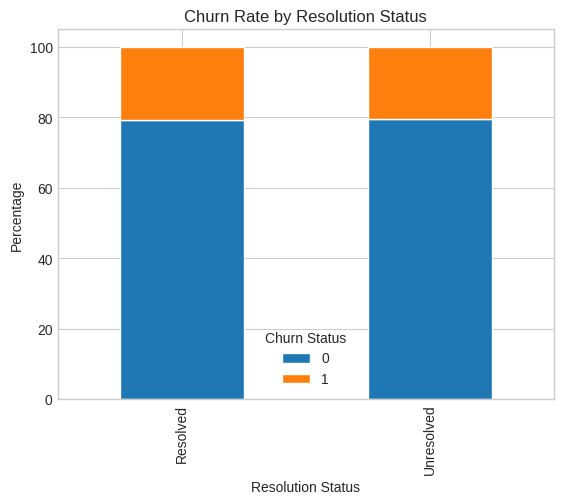

In [106]:

# Resolution Status analysis
plt.figure(figsize=(12, 6))
resolution_churn = pd.crosstab(df_full['ResolutionStatus'], df_full['ChurnStatus'], normalize='index') * 100
resolution_churn.plot(kind='bar', stacked=True)
plt.title('Churn Rate by Resolution Status')
plt.xlabel('Resolution Status')
plt.ylabel('Percentage')
plt.legend(title='Churn Status')
plt.show()

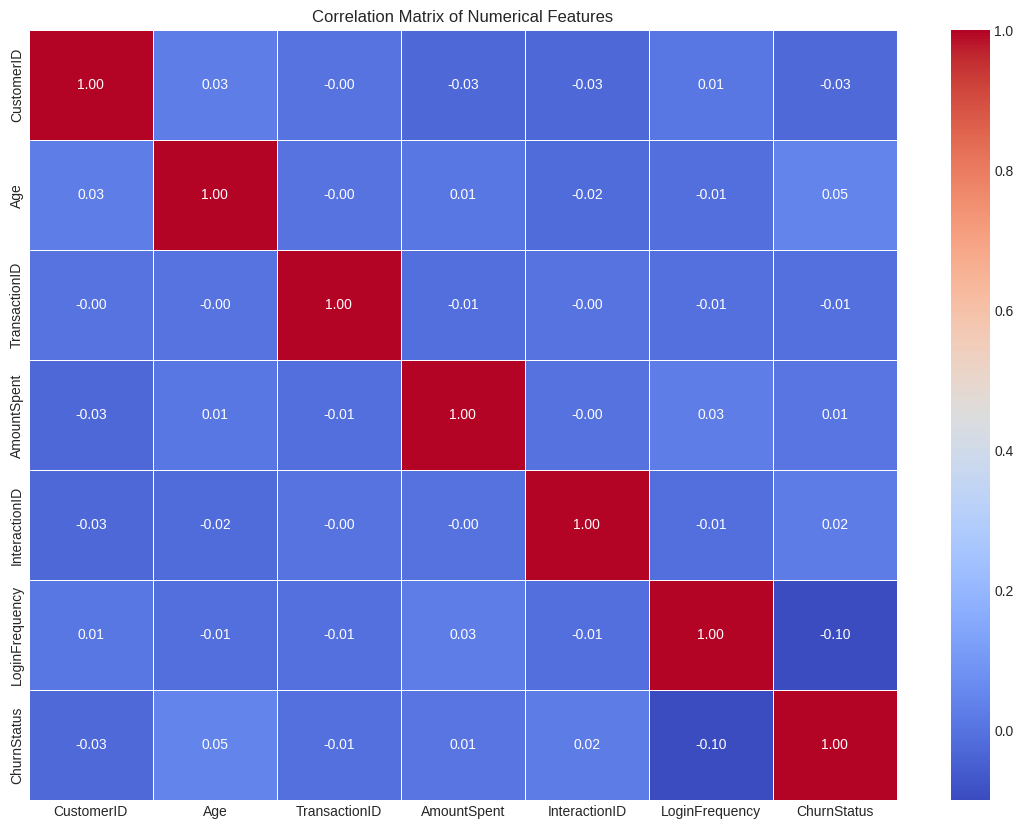

In [107]:
# Correlation analysis
# Select numeric columns for correlation
numeric_df = df_full.select_dtypes(include=['int64', 'float64'])

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [108]:
print("\n===== DATA PREPARATION FOR MODELING =====")



===== DATA PREPARATION FOR MODELING =====


In [109]:
# Identify categorical and numerical features
categorical_features = df_full.select_dtypes(include=['object']).columns.tolist()
numerical_features = df_full.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove the target variable and non-predictive features from the lists
if 'ChurnStatus' in categorical_features:
    categorical_features.remove('ChurnStatus')
if 'CustomerID' in categorical_features:
    categorical_features.remove('CustomerID')
if 'CustomerID' in numerical_features:
    numerical_features.remove('CustomerID')
if 'ChurnStatus' in numerical_features:
    numerical_features.remove('ChurnStatus')
if 'TransactionID' in numerical_features:
    numerical_features.remove('TransactionID')
if 'InteractionID' in numerical_features:
    numerical_features.remove('InteractionID')

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

Categorical features: ['Gender', 'MaritalStatus', 'IncomeLevel', 'ProductCategory', 'InteractionType', 'ResolutionStatus', 'ServiceUsage']
Numerical features: ['Age', 'AmountSpent', 'LoginFrequency']


In [110]:
# Handle datetime features
datetime_features = df_full.select_dtypes(include=['datetime64']).columns.tolist()
for feature in datetime_features:
    # Extract useful components from date
    df_full[f'{feature}_Year'] = df_full[feature].dt.year
    df_full[f'{feature}_Month'] = df_full[feature].dt.month
    df_full[f'{feature}_Day'] = df_full[feature].dt.day
    df_full[f'{feature}_DayOfWeek'] = df_full[feature].dt.dayofweek

    # Add to numerical features
    numerical_features.extend([f'{feature}_Year', f'{feature}_Month', f'{feature}_Day', f'{feature}_DayOfWeek'])

# Prepare features and target variable
X = df_full.drop(['CustomerID', 'ChurnStatus'] + datetime_features, axis=1)
y = df_full['ChurnStatus'].astype(int)  # Convert to int if it's boolean


In [54]:
# Prepare features and target variable
X = df_full.drop(['CustomerID', 'ChurnStatus'] + datetime_features, axis=1)
y = df_full['ChurnStatus'].astype(int)  # Convert to int if it's boolean


In [111]:
# Create preprocessing pipeline
# Numerical pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# Combine transformers in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [112]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5449, 24)
Testing set shape: (1363, 24)


In [58]:
print("\n===== PHASE 2: MODEL BUILDING AND EVALUATION =====")


===== PHASE 2: MODEL BUILDING AND EVALUATION =====


In [113]:
# Create model pipelines
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(random_state=42))
    ])
}


Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.7990
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC: 0.6014

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1092
           1       0.00      0.00      0.00       271

    accuracy                           0.80      1363
   macro avg       0.40      0.50      0.44      1363
weighted avg       0.64      0.80      0.71      1363



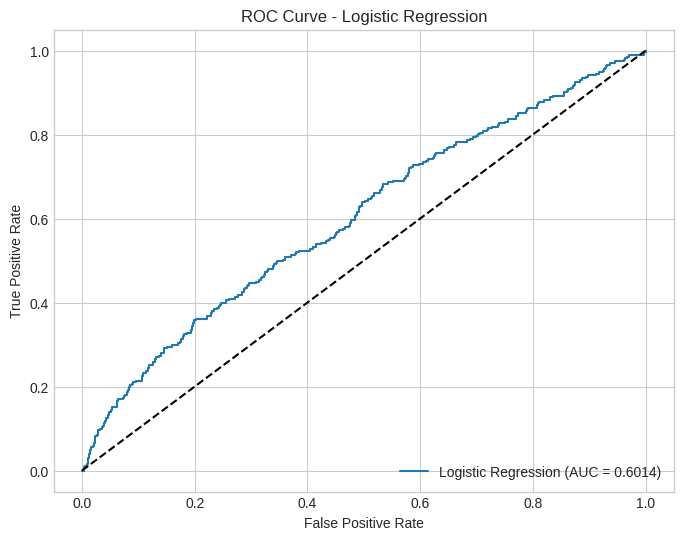

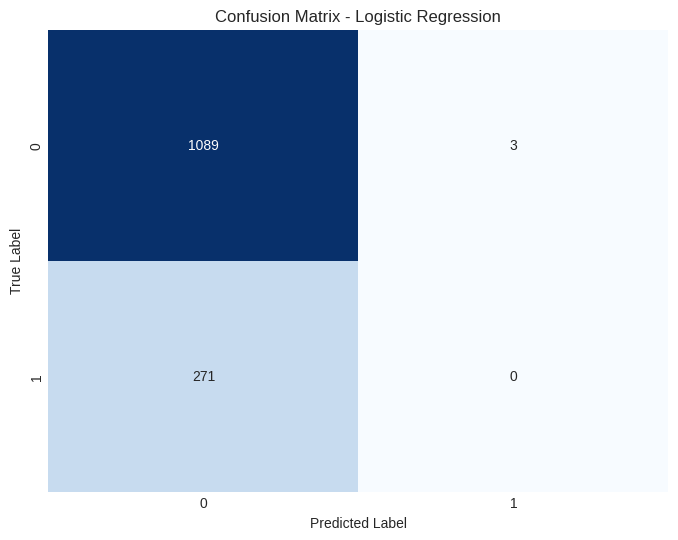


Training Random Forest...

Random Forest Results:
Accuracy: 0.9787
Precision: 1.0000
Recall: 0.8930
F1 Score: 0.9435
AUC: 0.9978

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1092
           1       1.00      0.89      0.94       271

    accuracy                           0.98      1363
   macro avg       0.99      0.95      0.97      1363
weighted avg       0.98      0.98      0.98      1363



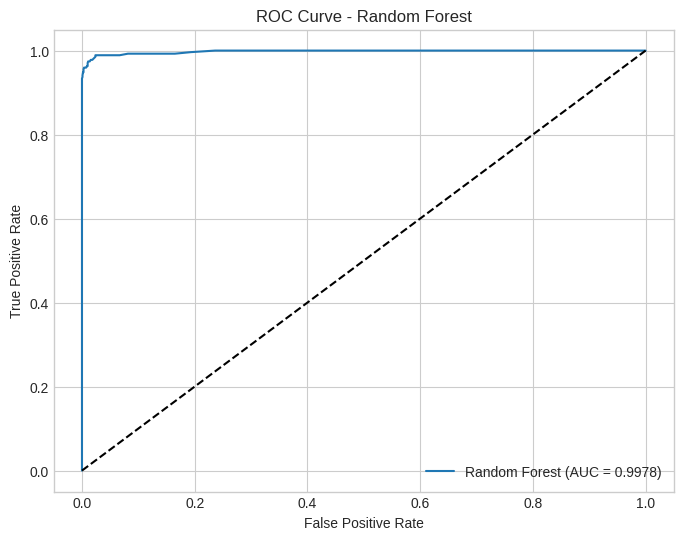

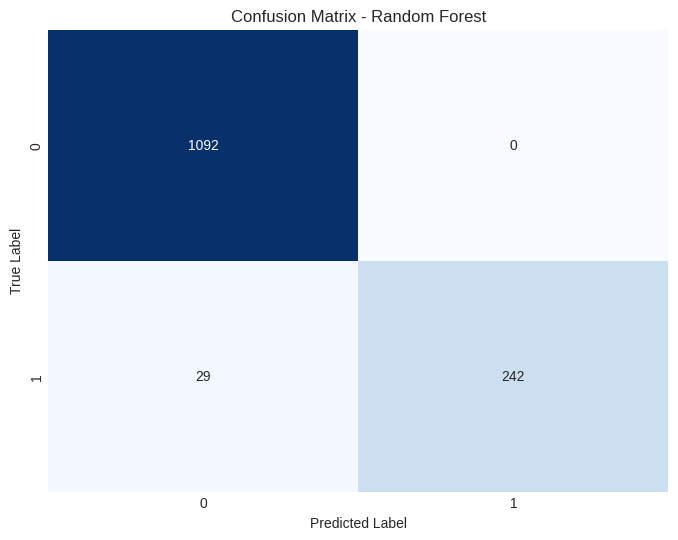


Training Gradient Boosting...

Gradient Boosting Results:
Accuracy: 0.8577
Precision: 0.9231
Recall: 0.3100
F1 Score: 0.4641
AUC: 0.8798

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1092
           1       0.92      0.31      0.46       271

    accuracy                           0.86      1363
   macro avg       0.89      0.65      0.69      1363
weighted avg       0.87      0.86      0.83      1363



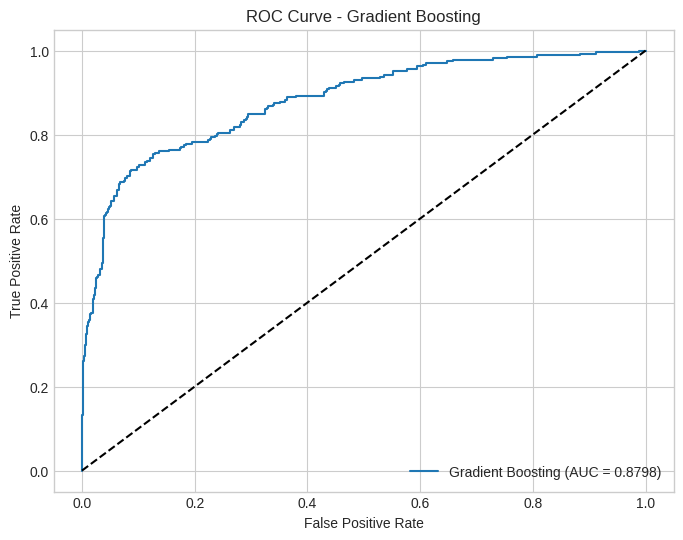

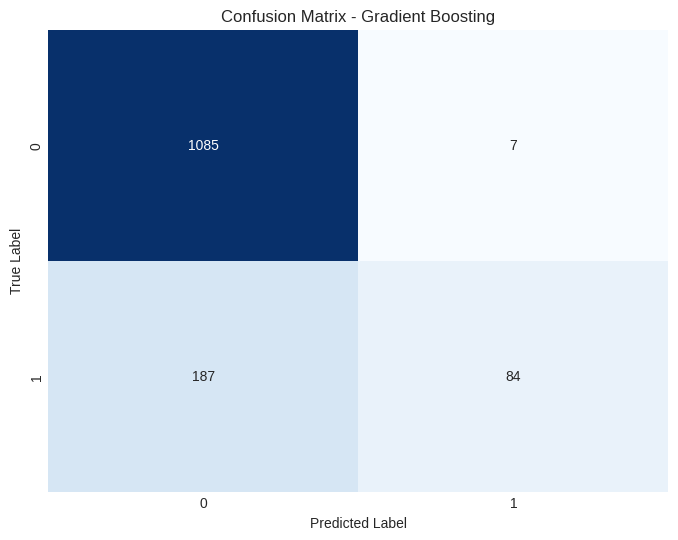


Training XGBoost...

XGBoost Results:
Accuracy: 0.9897
Precision: 0.9961
Recall: 0.9520
F1 Score: 0.9736
AUC: 0.9982

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1092
           1       1.00      0.95      0.97       271

    accuracy                           0.99      1363
   macro avg       0.99      0.98      0.98      1363
weighted avg       0.99      0.99      0.99      1363



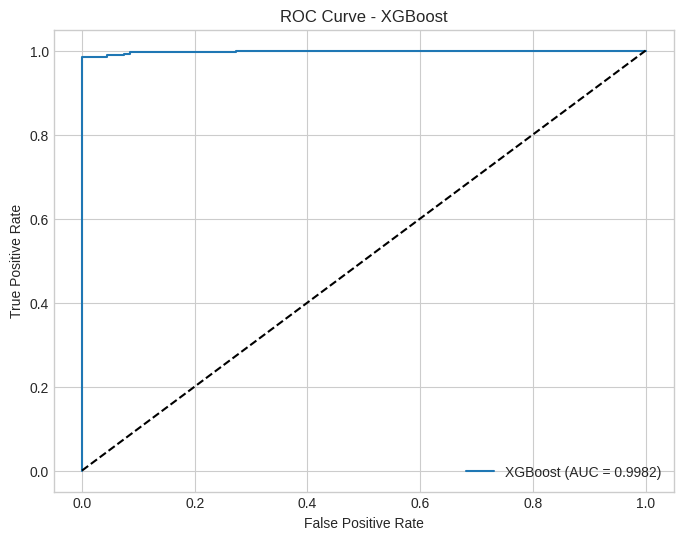

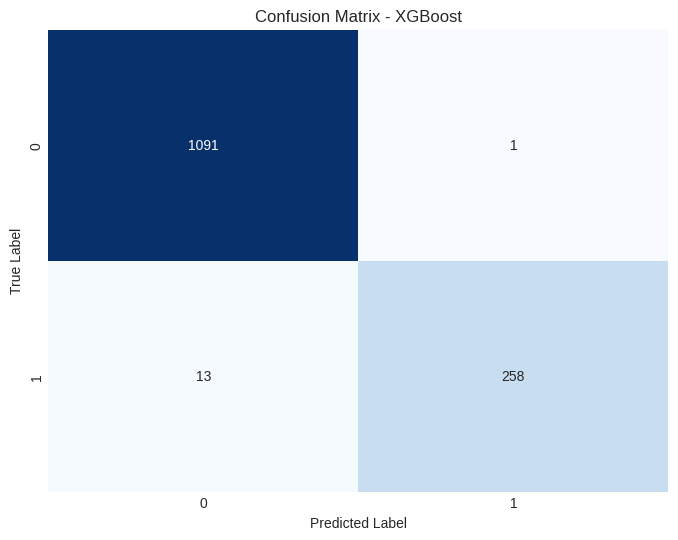


Model Comparison:
                     Accuracy  Precision    Recall  F1 Score       AUC
Logistic Regression  0.798973   0.000000  0.000000  0.000000  0.601449
Random Forest        0.978723   1.000000  0.892989  0.943470  0.997785
Gradient Boosting    0.857667   0.923077  0.309963  0.464088  0.879834
XGBoost              0.989729   0.996139  0.952030  0.973585  0.998209


In [114]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }

    # Print results
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Compare model performance
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)


<Figure size 1200x800 with 0 Axes>

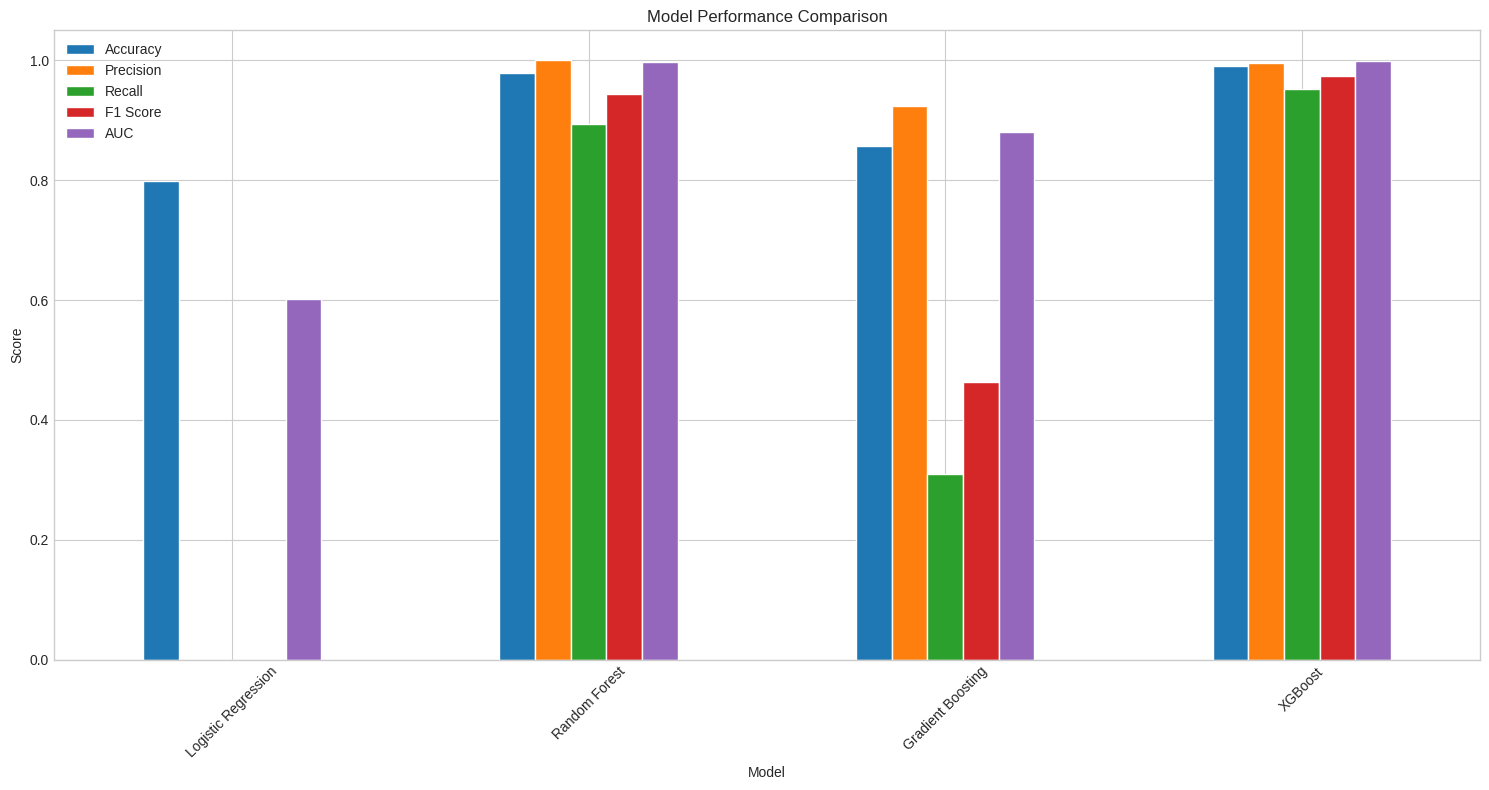

In [115]:
# Plot model comparison
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(15, 8))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [116]:
# Find the best model
best_model_name = results_df['F1 Score'].idxmax()
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with F1 Score: {results_df.loc[best_model_name, 'F1 Score']:.4f}")

# Hyperparameter tuning for the best model
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Logistic Regression':
    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_child_weight': [1, 3, 5]
    }


Best Model: XGBoost with F1 Score: 0.9736

Performing hyperparameter tuning for XGBoost...


In [122]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Build pipeline including preprocessing and SMOTE
final_cv_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(**grid_search.best_params_))  # best params
])

# Define stratified k-fold for balanced splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the full dataset
cv_scores = cross_val_score(
    final_cv_pipeline,
    X,  # Use full X (before split)
    y,  # Full y
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

print("\n=== Final Cross-Validation Results ===")
print(f"CV F1 Scores: {cv_scores}")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f}")



=== Final Cross-Validation Results ===
CV F1 Scores: [0.96168582 0.97570093 0.96969697 0.96749522 0.97142857]
Mean CV F1 Score: 0.9692


In [123]:
# Evaluate tuned model
best_tuned_model = grid_search.best_estimator_
y_pred_tuned = best_tuned_model.predict(X_test)
y_prob_tuned = best_tuned_model.predict_proba(X_test)[:, 1]

# Calculate metrics for tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
auc_tuned = roc_auc_score(y_test, y_prob_tuned)


In [124]:
print("\nTuned Model Results:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1 Score: {f1_tuned:.4f}")
print(f"AUC: {auc_tuned:.4f}")


Tuned Model Results:
Accuracy: 0.9934
Precision: 1.0000
Recall: 0.9668
F1 Score: 0.9831
AUC: 0.9980


In [125]:

# Print classification report for tuned model
print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))



Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1092
           1       1.00      0.97      0.98       271

    accuracy                           0.99      1363
   macro avg       1.00      0.98      0.99      1363
weighted avg       0.99      0.99      0.99      1363



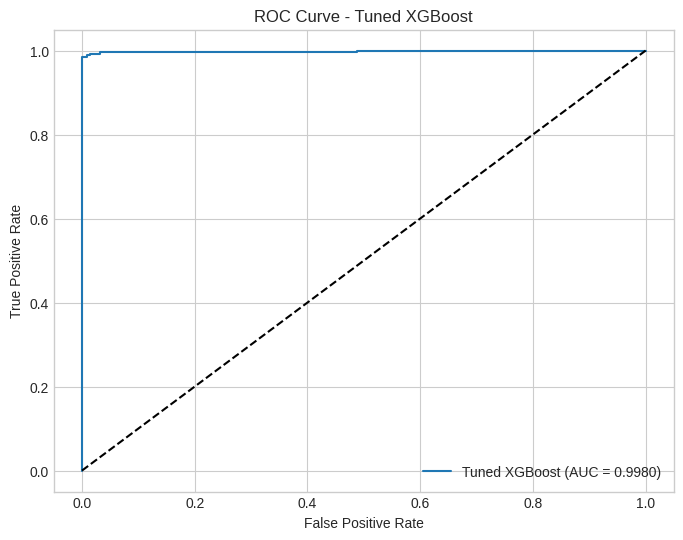

In [126]:
# Plot ROC curve for tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned {best_model_name} (AUC = {auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Tuned {best_model_name}')
plt.legend(loc='lower right')
plt.show()

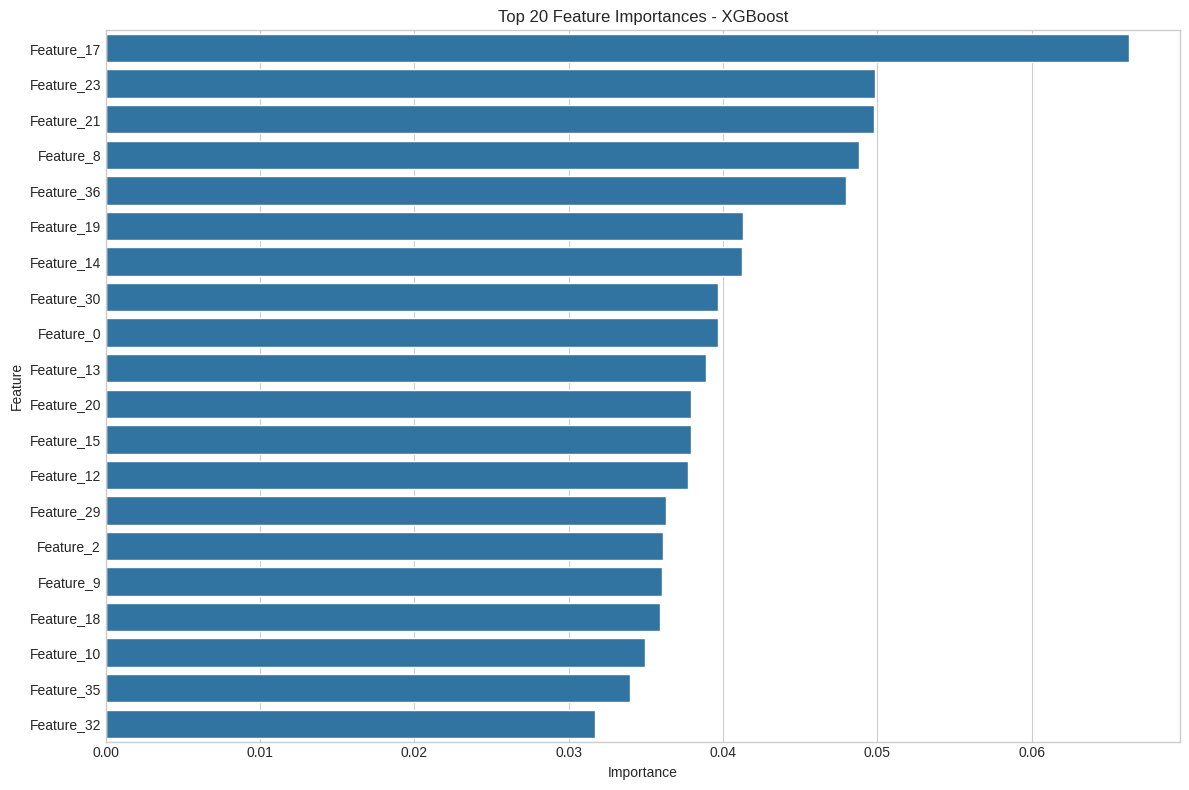


Top 10 Most Important Features:
   - Feature_17: 0.0663
   - Feature_23: 0.0498
   - Feature_21: 0.0498
   - Feature_8: 0.0488
   - Feature_36: 0.0480
   - Feature_19: 0.0413
   - Feature_14: 0.0412
   - Feature_30: 0.0397
   - Feature_0: 0.0397
   - Feature_13: 0.0389


In [127]:
# Feature importance analysis (if applicable)
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    try:
        # Extract feature importances from the best model
        importances = best_tuned_model.named_steps['classifier'].feature_importances_

        # Get feature names - a simpler approach to avoid errors
        # First apply the preprocessor to get the transformed feature count
        X_preprocessed = preprocessor.fit_transform(X_train)
        n_features = X_preprocessed.shape[1]

        # Create generic feature names if needed
        feature_names = [f"Feature_{i}" for i in range(n_features)]

        # Create a DataFrame for visualization
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })

        # Sort by importance
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

        # Plot feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
        plt.title(f'Top 20 Feature Importances - {best_model_name}')
        plt.tight_layout()
        plt.show()

        print("\nTop 10 Most Important Features:")
        for i, row in feature_importance_df.head(10).iterrows():
            print(f"   - {row['Feature']}: {row['Importance']:.4f}")
    except Exception as e:
        print(f"Could not extract feature importances: {e}")
        print("This can happen due to preprocessing pipeline complexity.")
        print("Consider using model-specific methods to extract feature importance.")


### 📊 Phase 3: Final Evaluation on Train/Test Split

After performing hyperparameter tuning and final cross-validation with SMOTE, we now evaluate the **best-tuned model** on the original training and test sets. This allows us to compare the model's performance and detect potential overfitting.


In [130]:
from sklearn.metrics import classification_report, confusion_matrix

# Fit the best model on training data
best_tuned_model = grid_search.best_estimator_
best_tuned_model.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = best_tuned_model.predict(X_train)
y_test_pred = best_tuned_model.predict(X_test)

# Predicted probabilities
y_train_prob = best_tuned_model.predict_proba(X_train)[:, 1]
y_test_prob = best_tuned_model.predict_proba(X_test)[:, 1]

# Training metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_prob)

# Test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_prob)

# Display results
print("=== Final Tuned Model Evaluation ===")
print(f"Training Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}, AUC: {train_auc:.4f}")
print(f"Test Accuracy:    {test_accuracy:.4f}, F1 Score: {test_f1:.4f}, AUC: {test_auc:.4f}")



=== Final Tuned Model Evaluation ===
Training Accuracy: 1.0000, F1 Score: 1.0000, AUC: 1.0000
Test Accuracy:    0.9934, F1 Score: 0.9831, AUC: 0.9980



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1092
           1       1.00      0.97      0.98       271

    accuracy                           0.99      1363
   macro avg       1.00      0.98      0.99      1363
weighted avg       0.99      0.99      0.99      1363



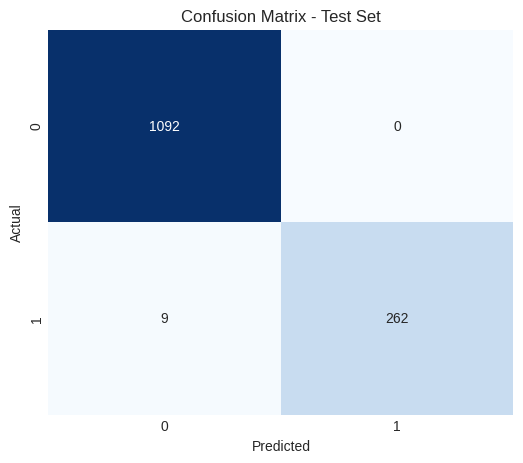

In [131]:
# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
